In [2]:
#from pyreaddbc import readdbc

#for i in range(2010, 2013):
    #readdbc.dbc2dbf(f'data/DOPB{i}.DBC', f'data/DOPB{i}.DBF')

In [3]:
import pandas as pd
from dbfread import DBF

df_list = []

for i in range(10, 23):
    file = DBF(f'data/DOPB20{i}.dbf', load=True)
    print(file)
    df = pd.DataFrame(file)
    df_list.append(df)

<loaded DBF table 'data/DOPB2010.dbf'>
<loaded DBF table 'data/DOPB2011.dbf'>
<loaded DBF table 'data/DOPB2012.dbf'>
<loaded DBF table 'data/DOPB2013.dbf'>
<loaded DBF table 'data/DOPB2014.dbf'>
<loaded DBF table 'data/DOPB2015.dbf'>
<loaded DBF table 'data/DOPB2016.dbf'>
<loaded DBF table 'data/DOPB2017.dbf'>
<loaded DBF table 'data/DOPB2018.dbf'>
<loaded DBF table 'data/DOPB2019.dbf'>
<loaded DBF table 'data/DOPB2020.dbf'>
<loaded DBF table 'data/DOPB2021.dbf'>
<loaded DBF table 'data/DOPB2022.dbf'>


In [4]:
df_concat = pd.DataFrame()

for df in df_list:
    df_concat = pd.concat([df_concat, df])

len(df_list)

13

In [254]:
from numpy import nan

columns = ['DTOBITO','CONTADOR','OCUP', 'HORAOBITO','NATURAL','CODMUNNATU','DTNASC','IDADE','SEXO','RACACOR','ESTCIV','ESC2010','CODMUNRES','LOCOCOR','CODMUNOCOR','CIRCOBITO','FONTE', 'TIPOBITO']

df_hom = (df_concat
 .filter(columns)
 .drop_duplicates()
 .replace('', nan)
 .query('CIRCOBITO == "3"')
 .query('TIPOBITO == "2"')
 .astype({'ESC2010': float})
 .reset_index().drop('index', axis=1)
)

df_hom['DTOBITO'] = df_hom['DTOBITO'].apply(lambda x: x[-4:])

In [255]:
qtd_linhas = df_concat.shape[0]

(df_hom
 .query('ESC2010 == 9').shape[0] # possivel limitação devido ao 9 == ignorado
)

4353

In [256]:
(df_hom
 .groupby('ESC2010', dropna=False)['CONTADOR'].count()
 #.apply(lambda x: (x/qtd_linhas) * 100).sum()
)

ESC2010
0.0     335
1.0    2009
2.0    1319
3.0     505
4.0      43
5.0      85
9.0    4353
NaN    8189
Name: CONTADOR, dtype: int64

<Axes: xlabel='LOCOCOR'>

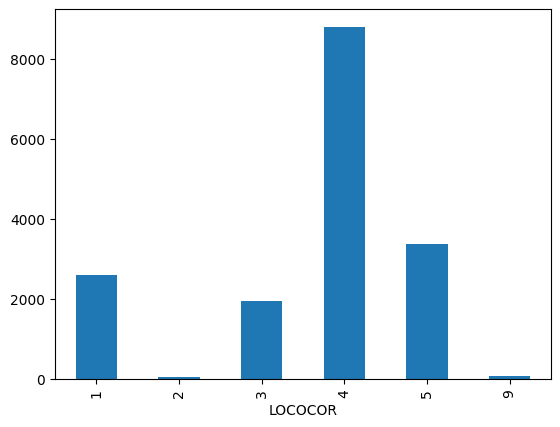

In [257]:
df_hom.groupby('LOCOCOR')['CONTADOR'].count().plot(kind='bar') # 4 - via pública é o maior

In [258]:
df_hom.groupby('FONTE', dropna=False)['CONTADOR'].count()#.plot(kind='bar')#.sum()

FONTE
1      11530
2         61
3         18
4        118
9        151
NaN     4960
Name: CONTADOR, dtype: int64

In [259]:
(df_hom
 .reset_index()
 .drop('index', axis=1)
 .query("IDADE.str.startswith('4') == False")
 .groupby('IDADE')['CONTADOR'].count().sum()
) # 54 não tem idade definida (indigente ou cpf perdido...)

np.int64(54)

In [260]:
df_hom.query("NATURAL.str.startswith('8') and NATURAL != '999' and NATURAL.str.endswith('25') == False").groupby('NATURAL')['CONTADOR'].count()

NATURAL
8        1
800    292
812      1
813      3
815      2
821      7
822      2
823     42
824    169
826    434
827     18
828      4
829     26
831      4
833    108
835    119
841      4
842      2
85       3
851      3
852      1
853     10
Name: CONTADOR, dtype: int64

<Axes: xlabel='ESC2010'>

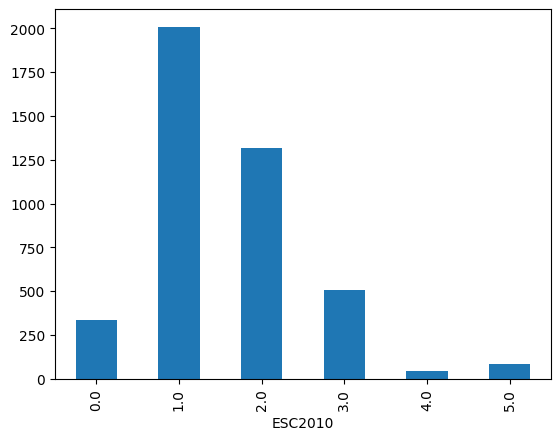

In [261]:
df_hom.groupby('ESC2010')['CONTADOR'].count().drop(9).plot(kind='bar')

In [262]:
df_hom.groupby('DTOBITO')['CONTADOR'].count()

DTOBITO
2010    1364
2011    1555
2012    1460
2013    1511
2014    1521
2015    1487
2016    1301
2017    1314
2018    1201
2019     861
2020    1092
2021    1099
2022    1072
Name: CONTADOR, dtype: int64

# Leitura dos dados das populações

In [263]:
pop0120 = pd.read_excel('data/pop0120.xls', header=4).iloc[15].drop('Unidades da Federação').astype(int)
pop0120

2001    3468594
2002    3494893
2003    3518595
2004    3568350
2005    3595886
2006    3623215
2007    3641397
2008    3742606
2009    3769977
2010    3766834
2011    3791315
2012    3815171
2013    3914421
2014    3943885
2015    3972202
2016    3999415
2017    4025558
2018    3996496
2019    4018127
2020    4039277
Name: 15, dtype: int64

In [264]:
pop2021 = (pd.read_excel('data/pop2021.xls').iloc[15].rename({'Unnamed: 2': '2021'})
.drop(['ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2021', 'Unnamed: 1'])).astype(int)
pop2021

2021    4059905
Name: 15, dtype: int64

In [265]:
pop2022 = pd.read_excel('data/pop2022.xlsx', header=2).drop('Unnamed: 0', axis=1).dropna(subset='COD. UF').query('UF == "PB"').groupby('UF')['POP. TOTAL'].sum().rename({'PB': 2022}).astype(int)
pop2022

UF
2022    3974687
Name: POP. TOTAL, dtype: int64

# Juntando dados IBGE com SIM

In [266]:
pop = pd.concat([pop0120, pop2021, pop2022])
pop = pop.reset_index().rename(columns={'index': 'DTOBITO',0: 'POPULACAO'}).drop(range(0, 9)).reset_index().drop('index', axis=1)
taxa_hom = df_hom.groupby('DTOBITO')['CONTADOR'].count().reset_index().rename(columns={'CONTADOR': 'HOMICIDIOS'})

In [267]:
#display(pop)
#display(taxa_hom)
taxa_hom = taxa_hom.merge(pop, how='outer', left_index=True, right_index=True).drop('DTOBITO_y', axis=1).rename(columns={'DTOBITO_x': 'ANO'})

In [268]:
taxa_hom

,ANO,HOMICIDIOS,POPULACAO
0,2010,1364,3766834
1,2011,1555,3791315
2,2012,1460,3815171
3,2013,1511,3914421
4,2014,1521,3943885
5,2015,1487,3972202
6,2016,1301,3999415
7,2017,1314,4025558
8,2018,1201,3996496
9,2019,861,4018127


# Calculando taxa de homicídio

In [269]:
hom = taxa_hom.assign(TAXA=lambda x: round((x['HOMICIDIOS']/x['POPULACAO']) * 100000, 3))
hom

,ANO,HOMICIDIOS,POPULACAO,TAXA
0,2010,1364,3766834,36.211
1,2011,1555,3791315,41.015
2,2012,1460,3815171,38.268
3,2013,1511,3914421,38.601
4,2014,1521,3943885,38.566
5,2015,1487,3972202,37.435
6,2016,1301,3999415,32.530
7,2017,1314,4025558,32.641
8,2018,1201,3996496,30.051
9,2019,861,4018127,21.428


<Axes: xlabel='ANO'>

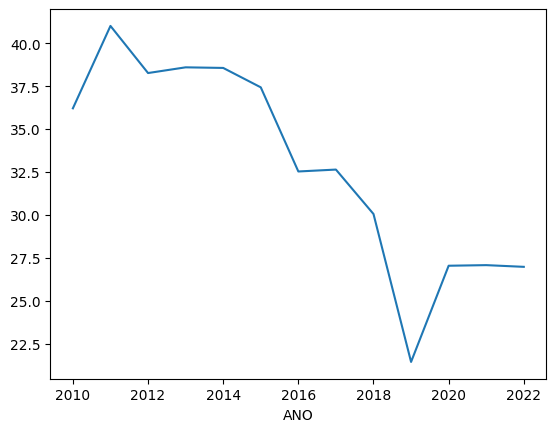

In [270]:
hom.groupby('ANO')['TAXA'].sum().plot()

In [271]:
std_hom = hom.filter(['HOMICIDIOS', 'TAXA'])['TAXA'].std()

# Lendo dados do IPEA para comparação

In [272]:
taxa_ipea = pd.read_csv('data/taxa-homicidios-2010-01--01-2022-01--01.csv', sep=';').rename(columns={'período': 'ANO', 'valor': 'TAXA'}).filter(['ANO', 'TAXA'])
std_ipea = taxa_ipea['TAXA'].std()

round(abs(std_hom - std_ipea), 3)

np.float64(0.106)

# Analisando dados pela escolaridade

In [274]:
dist_esc = df_hom.groupby('ESC2010')['CONTADOR'].count()
dist_esc

ESC2010
0.0     335
1.0    2009
2.0    1319
3.0     505
4.0      43
5.0      85
9.0    4353
Name: CONTADOR, dtype: int64

Verificando de acordo com as informações de identificação e comparando (raça, idade, situação conjugal, etc.)